## Import Libraries

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

## Data Collection

In [3]:
DIRECTORY = r"C:\Users\Ishita Gupta\Face-Mask-Detection-master\dataset"
CATEGORIES = ["with_mask", "without_mask"]

In [17]:
data = []
labels = []

In [18]:
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

D:\Users\Ishita Gupta\anaconda3\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


## Data Preparation

In [19]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

## Train Test Split

In [20]:
(X_train, X_test, y_train, y_test) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

## Model Selection

In [21]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [22]:
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

In [23]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [25]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [26]:
for layer in baseModel.layers:
	layer.trainable = False

In [28]:
opt = Adam(learning_rate=1e-4, decay= 1e-4 / 10)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

## Model Training

In [29]:
history = model.fit(
	aug.flow(X_train, y_train, batch_size=32),
	steps_per_epoch=len(X_train) // 32,
	validation_data=(X_test, y_test),
	validation_steps=len(X_test) // 32,
	epochs=10
)

Epoch 1/10
95/95 [==============================] - 265s 3s/step - loss: 0.3655 - accuracy: 0.8695 - val_loss: 0.1300 - val_accuracy: 0.9844
Epoch 2/10
95/95 [==============================] - 210s 2s/step - loss: 0.1365 - accuracy: 0.9670 - val_loss: 0.0740 - val_accuracy: 0.9857
Epoch 3/10
95/95 [==============================] - 232s 2s/step - loss: 0.0983 - accuracy: 0.9743 - val_loss: 0.0547 - val_accuracy: 0.9883
Epoch 4/10
95/95 [==============================] - 233s 2s/step - loss: 0.0748 - accuracy: 0.9782 - val_loss: 0.0431 - val_accuracy: 0.9935
Epoch 5/10
95/95 [==============================] - 392s 4s/step - loss: 0.0698 - accuracy: 0.9819 - val_loss: 0.0402 - val_accuracy: 0.9922
Epoch 6/10
95/95 [==============================] - 390s 4s/step - loss: 0.0613 - accuracy: 0.9819 - val_loss: 0.0415 - val_accuracy: 0.9909
Epoch 7/10
95/95 [==============================] - 299s 3s/step - loss: 0.0503 - accuracy: 0.9868 - val_loss: 0.0326 - val_accuracy: 0.9935
Epoch 8/10
95

## Model Prediction

In [30]:
predIdxs = model.predict(X_test, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)

In [31]:
classification_report(y_test.argmax(axis=1), predIdxs, target_names=lb.classes_)

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



## Saving the model

In [32]:
model.save("mask_detector1.model", save_format="h5")

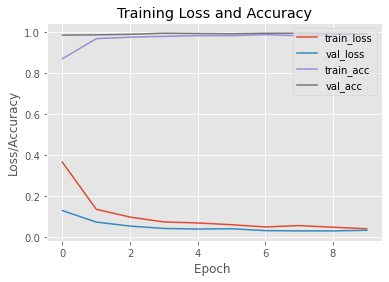

In [33]:
N = 10
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch ")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")